# Unskewing COVID-19 Case Count with Phylodynamic and Epidemiological Parameters
Kartik Chugh - May 3, 2020

Over the past few months, the coronavirus pandemic has devastated communities on a global scale, with roughly 3.5 million cases worldwide and over a million in the United States alone at the time of this writing. Key to the virus' wildfire-like spread has been "cryptic transmission", whereby asymptomatic carriers pass it along unknowingly to others. The US, with its tepid testing and tracing measures and low governmental preparedness, is thought to have been particularly afflicted by this phenomenon for long periods of time: viral dynamics research suggests that the coronavirus must have been spreading silently across the nation for weeks before taking off in March. 

 <img src="china-data.png" />

In this project, I derive estimates for true case counts from January to present. My methodology is based on the work of (Tomas Pueyo)[https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca]__, whose estimation technique has been endorsed by over 500 medical experts and virologists. I extend his core idea in two key ways: 1) I 

In [105]:
import numpy as np
import pandas as pd
from pandas import Timestamp, Series
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.3f}'.format})

%config InlineBackend.figure_format = 'retina'

In [106]:
ONSET_TO_DEATH = 17 # https://midasnetwork.us/covid-19/
MORTALITY_RATE = 0.01

In [107]:
url = 'https://covidtracking.com/api/v1/us/daily.csv' # https://covidtracking.com/api
df = pd.read_csv(url, 
            usecols=['date', 'positiveIncrease', 'deathIncrease', 'positive'], 
            parse_dates=['date'], 
            index_col=['date']).sort_index().iloc[1:]

time = df.index

In [108]:
pd.set_option('display.max_rows', None)
df

,positive,deathIncrease,positiveIncrease
date,,,
2020-01-23,1,0.0,0.0
2020-01-24,1,0.0,0.0
2020-01-25,1,0.0,0.0
2020-01-26,1,0.0,0.0
2020-01-27,1,0.0,0.0
2020-01-28,1,0.0,0.0
2020-01-29,1,0.0,0.0
2020-01-30,1,0.0,0.0
2020-01-31,1,0.0,0.0


In [109]:
def doublingTime(a, b):
    return np.log(2)/np.log(b/a) if (a != b) else np.nan

lower = 2.4
doubling = np.zeros(df['positive'].shape)
for t in range(1, len(doubling)):
    doubling[t] = doublingTime(df['positive'][t-1], df['positive'][t])
    
doubling_orig = pd.DataFrame(doubling, columns=['doubling time'], index=time)
    
doubling_smooth = doubling_orig.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=3).round().clip(lower=lower).fillna(lower)

In [110]:
doubling_smooth

,doubling time
date,
2020-01-23,2.4
2020-01-24,2.4
2020-01-25,2.4
2020-01-26,2.4
2020-01-27,2.4
2020-01-28,2.4
2020-01-29,2.4
2020-01-30,2.4
2020-01-31,2.4


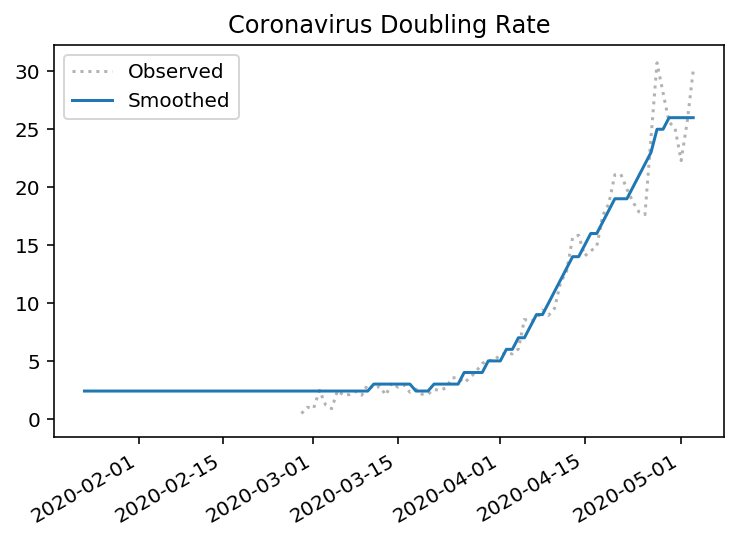

In [111]:
plt.plot(doubling_orig, c='k', ls=':', alpha=.3)
plt.plot(doubling_smooth)
plt.gcf().autofmt_xdate()
plt.legend(['Observed', 'Smoothed'])
plt.title('Coronavirus Doubling Rate')
plt.show()

In [112]:
t_init = df['deathIncrease'].ne(0).idxmax()
t_init

Timestamp('2020-02-26 00:00:00')

In [113]:
d_init = df['deathIncrease'][t_init]
d_init

2.0

In [114]:
t0 = t_init - timedelta(days=ONSET_TO_DEATH)
t0

Timestamp('2020-02-09 00:00:00')

In [115]:
C0 = d_init * 1/MORTALITY_RATE
C0

200.0

In [116]:
C = np.full(df['positive'].shape, C0)

In [117]:
cf = 0.75

for t in range((t0-time[0]).days, -1, -1):
    db = doubling_smooth['doubling time'][t]
    C[t] = C[t+1] / 2**(1/db * cf)

for t in range((t0-time[0]).days, len(C)):
    db = doubling_smooth['doubling time'][t]
    C[t] = C[t-1] * 2**(1/db * cf)

In [118]:
C

array([4.053, 5.033, 6.250, 7.762, 9.639, 11.970, 14.865, 18.460, 22.925,
       28.470, 35.355, 43.906, 54.525, 67.713, 84.090, 104.427, 129.684,
       161.049, 200.000, 248.372, 308.442, 383.041, 475.683, 590.730,
       733.603, 911.031, 1131.371, 1405.002, 1744.812, 2166.809, 2690.869,
       3341.676, 4149.887, 5153.569, 6400.000, 7947.890, 9870.149,
       12257.322, 15221.851, 18903.375, 23475.304, 29152.989, 36203.867,
       44960.055, 55833.996, 69337.884, 86107.793, 106933.635, 127166.240,
       151226.997, 179840.221, 213867.271, 254332.480, 302453.995,
       359680.442, 446671.967, 554703.072, 688862.343, 819200.000,
       974198.469, 1158523.750, 1377724.687, 1638400.000, 1865791.299,
       2124741.926, 2419631.958, 2755449.374, 3057362.507, 3392356.102,
       3764054.770, 4104730.832, 4476240.713, 4821327.654, 5193018.391,
       5541679.727, 5871205.151, 6220325.177, 6552248.172, 6869341.556,
       7173473.289, 7466148.104, 7748599.382, 8041736.052, 8325327.262,


In [119]:
df['true'] = C.round()
df

,positive,deathIncrease,positiveIncrease,true
date,,,,
2020-01-23,1,0.0,0.0,4.0
2020-01-24,1,0.0,0.0,5.0
2020-01-25,1,0.0,0.0,6.0
2020-01-26,1,0.0,0.0,8.0
2020-01-27,1,0.0,0.0,10.0
2020-01-28,1,0.0,0.0,12.0
2020-01-29,1,0.0,0.0,15.0
2020-01-30,1,0.0,0.0,18.0
2020-01-31,1,0.0,0.0,23.0


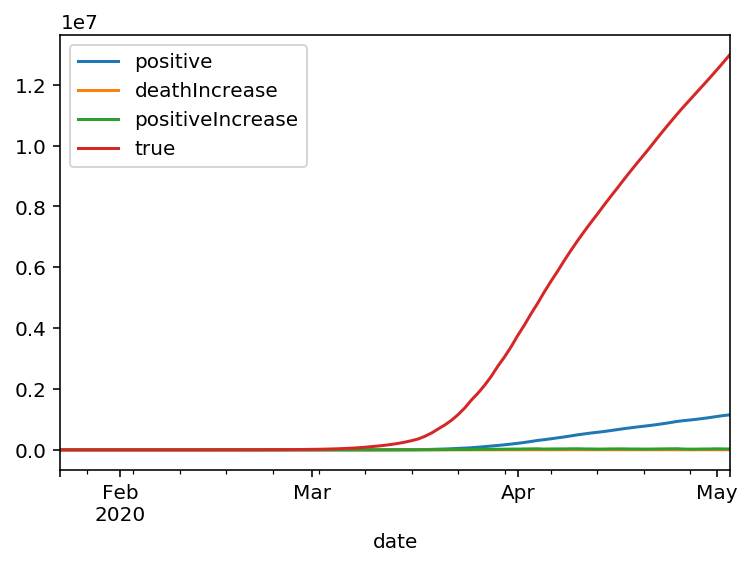

In [120]:
df.plot()